## Heteroscedastic uncertainty

### Example of learning the aleatoric heteroscedastic uncertainty by learning a simple linear regression

In [1]:
#!pip install keras==2.0.8
from keras.callbacks import TensorBoard
from keras.layers import Input, Dense, concatenate, Flatten
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop, Nadam
from keras.initializers import RandomNormal
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


First we create some samples from 0 to 10 and add some noise

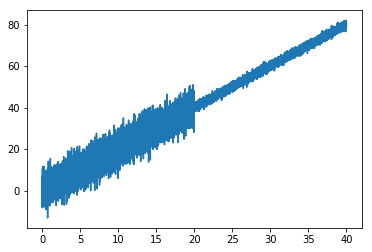

In [10]:
x = np.linspace(0, 20, 10000)#, dtype="int32")  # 100000 values between 0 and 100
delta = np.random.normal(0, 4, x.size)
y = 2*x + delta
x2 = np.linspace(20, 40, 10000)
delta2 = np.random.normal(0, 1, x2.size)
y2 = 2*x2 + delta2
x = np.append(x, x2)
y = np.append(y, y2)
plt.plot(x,y)
plt.show()

These are the function used to include the calculation of the sigmas in the loss.
Note that we use the trick of concatenating the sigma to the ouput, so the prediction is at index 0 and the sigma is at index 1 of the resulting output.

In [11]:
def aleatoric_loss(y_true, y_pred):
    sigma = y_pred[:, 1]
    epsilon = 1e-6
    y_pred_prima = y_pred[:, 0]
    output_value = ((K.square(y_pred_prima - y_true[:, 0])) / (K.square(sigma) + epsilon)) + K.log(K.square(sigma) + epsilon)
    return K.mean(output_value, axis=-1)

def aleatoric_rms(y_true, y_pred):
    y_pred_prima = y_pred[:, 0]
    return K.mean(K.square(y_pred_prima - y_true[:, 0]), axis=-1)

def aleatoric_uncertainty(y_true, y_pred):
    sigma = y_pred[:, 1]
    return K.max(K.log(K.square(sigma)), axis=-1)

In [12]:
tensorboard_cb = TensorBoard(
            log_dir='data/Uncertain_LR',
            histogram_freq=0, write_grads=True,
            write_graph=True, write_images=False, embeddings_freq=1)

First we try a model without calculating the sigma and plot some results.

Epoch 1/20
20000/20000 [==============================] - 0s 17us/step - loss: 99.0856 - mean_squared_error: 99.0856
Epoch 2/20
20000/20000 [==============================] - 0s 9us/step - loss: 48.6765 - mean_squared_error: 48.6765
Epoch 3/20
20000/20000 [==============================] - 0s 9us/step - loss: 26.2433 - mean_squared_error: 26.2433
Epoch 4/20
20000/20000 [==============================] - 0s 9us/step - loss: 15.4376 - mean_squared_error: 15.4376
Epoch 5/20
20000/20000 [==============================] - 0s 9us/step - loss: 10.8339 - mean_squared_error: 10.8339
Epoch 6/20
20000/20000 [==============================] - 0s 9us/step - loss: 9.1625 - mean_squared_error: 9.1625
Epoch 7/20
20000/20000 [==============================] - 0s 9us/step - loss: 8.6600 - mean_squared_error: 8.6600
Epoch 8/20
20000/20000 [==============================] - 0s 9us/step - loss: 8.5392 - mean_squared_error: 8.5392
Epoch 9/20
20000/20000 [==============================] - 0s 9us/step - loss:

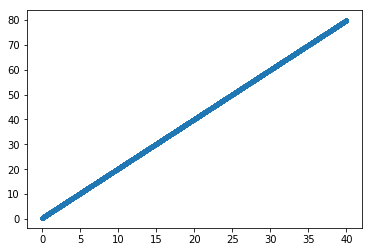

In [13]:
raw_inputs = Input(shape=(1,))
raw_preds = Dense(1, activation='linear', name="preds")(raw_inputs)

rawmodel = Model(inputs=raw_inputs,outputs=raw_preds)
rawmodel.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
rawmodel.fit(x, y, batch_size=128, epochs=20, shuffle=False)
x_raw_pred = np.array([1,2,3,4,5,6,7,8,9,10,15,20])
raw_result = rawmodel.predict(x)
plt.plot(x, raw_result[:,0],'.')
plt.show()

Then we try a model where the sigma is the result of a sigmoid activation.

In [14]:
inputs = Input(shape=(1,))
sigma = Dense(10, activation='relu', name="sigma", kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), use_bias=True)(inputs)
sigma2 = Dense(5, activation='relu', name="sigma2", kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), use_bias=True)(sigma)
sigma3 = Dense(1, activation='linear', name="sigma3", kernel_initializer=RandomNormal(mean=0.0, stddev=0.05, seed=None), use_bias=True)(sigma2)
preds = Dense(1, activation='linear', name="preds")(inputs)
aleatoric_output = concatenate([preds, sigma3])
sgd = SGD(lr=0.1)
adam = Adam(lr=0.001)
rms = RMSprop(lr=0.001)
nadam = Nadam(lr=0.001)
model = Model(inputs=inputs,outputs=aleatoric_output)
model.compile(optimizer=nadam, loss=aleatoric_loss, metrics=[aleatoric_rms, aleatoric_uncertainty])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
sigma (Dense)                   (None, 10)           20          input_4[0][0]                    
__________________________________________________________________________________________________
sigma2 (Dense)                  (None, 5)            55          sigma[0][0]                      
__________________________________________________________________________________________________
preds (Dense)                   (None, 1)            2           input_4[0][0]                    
__________________________________________________________________________________________________
sigma3 (De

In [15]:
model.fit(x, np.expand_dims(y, axis=1).repeat(2, axis=1), batch_size=64, epochs=300, shuffle=False)

Epoch 1/300
20000/20000 [==============================] - 1s 45us/step - loss: 304923.0414 - aleatoric_rms: 4126.0345 - aleatoric_uncertainty: -4.1494
Epoch 2/300
20000/20000 [==============================] - 0s 22us/step - loss: 17648.8829 - aleatoric_rms: 4033.5553 - aleatoric_uncertainty: -2.2396
Epoch 3/300
20000/20000 [==============================] - 0s 23us/step - loss: 9326.7774 - aleatoric_rms: 3972.8862 - aleatoric_uncertainty: -1.6178
Epoch 4/300
20000/20000 [==============================] - 0s 23us/step - loss: 6078.0625 - aleatoric_rms: 3923.7669 - aleatoric_uncertainty: -1.1966
Epoch 5/300
20000/20000 [==============================] - 0s 22us/step - loss: 4365.5849 - aleatoric_rms: 3880.9131 - aleatoric_uncertainty: -0.8703
Epoch 6/300
20000/20000 [==============================] - 0s 22us/step - loss: 3317.2285 - aleatoric_rms: 3841.9314 - aleatoric_uncertainty: -0.5996
Epoch 7/300
20000/20000 [==============================] - 0s 22us/step - loss: 2614.2990 - aleat

20000/20000 [==============================] - 0s 22us/step - loss: 8.9778 - aleatoric_rms: 1298.2235 - aleatoric_uncertainty: 5.4155
Epoch 57/300
20000/20000 [==============================] - 0s 22us/step - loss: 8.6388 - aleatoric_rms: 1215.2799 - aleatoric_uncertainty: 5.4904
Epoch 58/300
20000/20000 [==============================] - 0s 21us/step - loss: 8.3459 - aleatoric_rms: 1131.4622 - aleatoric_uncertainty: 5.5612
Epoch 59/300
20000/20000 [==============================] - 0s 22us/step - loss: 8.0928 - aleatoric_rms: 1046.9255 - aleatoric_uncertainty: 5.6274
Epoch 60/300
20000/20000 [==============================] - 0s 22us/step - loss: 7.8736 - aleatoric_rms: 961.8554 - aleatoric_uncertainty: 5.6885
Epoch 61/300
20000/20000 [==============================] - 0s 22us/step - loss: 7.6830 - aleatoric_rms: 876.4787 - aleatoric_uncertainty: 5.7436
Epoch 62/300
20000/20000 [==============================] - 0s 22us/step - loss: 7.5164 - aleatoric_rms: 791.0721 - aleatoric_uncerta

20000/20000 [==============================] - 0s 21us/step - loss: 2.4777 - aleatoric_rms: 8.4372 - aleatoric_uncertainty: 1.4897
Epoch 113/300
20000/20000 [==============================] - 0s 21us/step - loss: 2.4777 - aleatoric_rms: 8.4371 - aleatoric_uncertainty: 1.4899
Epoch 114/300
20000/20000 [==============================] - 0s 21us/step - loss: 2.4777 - aleatoric_rms: 8.4371 - aleatoric_uncertainty: 1.4900
Epoch 115/300
20000/20000 [==============================] - 0s 21us/step - loss: 2.4776 - aleatoric_rms: 8.4371 - aleatoric_uncertainty: 1.4900
Epoch 116/300
20000/20000 [==============================] - 0s 20us/step - loss: 2.4774 - aleatoric_rms: 8.4371 - aleatoric_uncertainty: 1.4900
Epoch 117/300
20000/20000 [==============================] - 1s 29us/step - loss: 2.4785 - aleatoric_rms: 8.4370 - aleatoric_uncertainty: 1.4884
Epoch 118/300
20000/20000 [==============================] - 0s 21us/step - loss: 2.4790 - aleatoric_rms: 8.4370 - aleatoric_uncertainty: 1.4895

20000/20000 [==============================] - 0s 20us/step - loss: 2.4893 - aleatoric_rms: 8.4368 - aleatoric_uncertainty: 1.5000
Epoch 169/300
20000/20000 [==============================] - 0s 20us/step - loss: 2.4897 - aleatoric_rms: 8.4368 - aleatoric_uncertainty: 1.4983
Epoch 170/300
20000/20000 [==============================] - 0s 21us/step - loss: 2.4898 - aleatoric_rms: 8.4368 - aleatoric_uncertainty: 1.4997
Epoch 171/300
20000/20000 [==============================] - 0s 21us/step - loss: 2.4900 - aleatoric_rms: 8.4368 - aleatoric_uncertainty: 1.4994
Epoch 172/300
20000/20000 [==============================] - 0s 21us/step - loss: 2.4903 - aleatoric_rms: 8.4368 - aleatoric_uncertainty: 1.4996
Epoch 173/300
20000/20000 [==============================] - 0s 21us/step - loss: 2.4906 - aleatoric_rms: 8.4368 - aleatoric_uncertainty: 1.4994
Epoch 174/300
20000/20000 [==============================] - 0s 21us/step - loss: 2.4907 - aleatoric_rms: 8.4368 - aleatoric_uncertainty: 1.5011

20000/20000 [==============================] - 0s 20us/step - loss: 2.4991 - aleatoric_rms: 8.4370 - aleatoric_uncertainty: 1.5067
Epoch 225/300
20000/20000 [==============================] - 0s 20us/step - loss: 2.4993 - aleatoric_rms: 8.4370 - aleatoric_uncertainty: 1.5067
Epoch 226/300
20000/20000 [==============================] - 0s 20us/step - loss: 2.4994 - aleatoric_rms: 8.4370 - aleatoric_uncertainty: 1.5069
Epoch 227/300
20000/20000 [==============================] - 1s 71us/step - loss: 2.4995 - aleatoric_rms: 8.4370 - aleatoric_uncertainty: 1.5071
Epoch 228/300
20000/20000 [==============================] - 0s 21us/step - loss: 2.4997 - aleatoric_rms: 8.4370 - aleatoric_uncertainty: 1.5072
Epoch 229/300
20000/20000 [==============================] - 0s 21us/step - loss: 2.4998 - aleatoric_rms: 8.4370 - aleatoric_uncertainty: 1.5074
Epoch 230/300
20000/20000 [==============================] - 0s 21us/step - loss: 2.5000 - aleatoric_rms: 8.4370 - aleatoric_uncertainty: 1.5075

20000/20000 [==============================] - 0s 22us/step - loss: 2.4957 - aleatoric_rms: 8.4372 - aleatoric_uncertainty: 1.4976
Epoch 281/300
20000/20000 [==============================] - 0s 21us/step - loss: 2.4920 - aleatoric_rms: 8.4372 - aleatoric_uncertainty: 1.4920
Epoch 282/300
20000/20000 [==============================] - 0s 21us/step - loss: 2.4882 - aleatoric_rms: 8.4372 - aleatoric_uncertainty: 1.4864
Epoch 283/300
20000/20000 [==============================] - 0s 21us/step - loss: 2.4842 - aleatoric_rms: 8.4372 - aleatoric_uncertainty: 1.4808
Epoch 284/300
20000/20000 [==============================] - 0s 21us/step - loss: 2.4803 - aleatoric_rms: 8.4372 - aleatoric_uncertainty: 1.4749
Epoch 285/300
20000/20000 [==============================] - 0s 20us/step - loss: 2.4767 - aleatoric_rms: 8.4372 - aleatoric_uncertainty: 1.4706
Epoch 286/300
20000/20000 [==============================] - 0s 20us/step - loss: 2.4729 - aleatoric_rms: 8.4371 - aleatoric_uncertainty: 1.4655

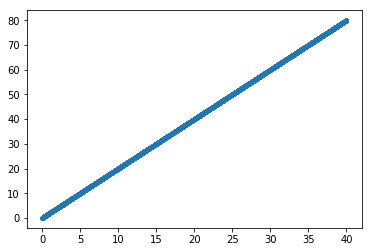

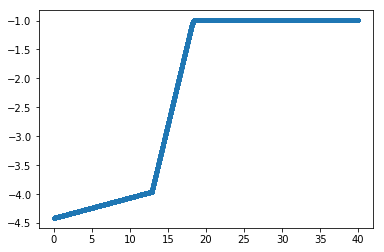

In [16]:
result = model.predict(x)
plt.plot(x, result[:,0],'.')
plt.show()
plt.plot(x, result[:,1],'.')
plt.show()
#result